# Time Series Modeling

## Decompostion of time series
### Systematic components
* level
* trend
* seasonality

## Non-systematic component
* Noise

## Getting the data

In [1]:
%matplotlib widget

In [108]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
import quandl
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns

In [109]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_theme(style='ticks', font_scale=1.2)
pd.options.plotting.backend = 'matplotlib'

In [223]:
ticker = "AMZN"
start = datetime(2020, 1, 1)
end = datetime(2022, 8, 1)
data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [224]:
data.rename(columns={'Adj Close': 'price'}, inplace=True)
df = data.loc[:, ['price']]
df = df.resample('d').last()
df.fillna(method='ffill', inplace=True)

In [225]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['price'].rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df['price'].rolling(window=WINDOW_SIZE).std()


<AxesSubplot:title={'center':'AMZN'}, xlabel='Date'>

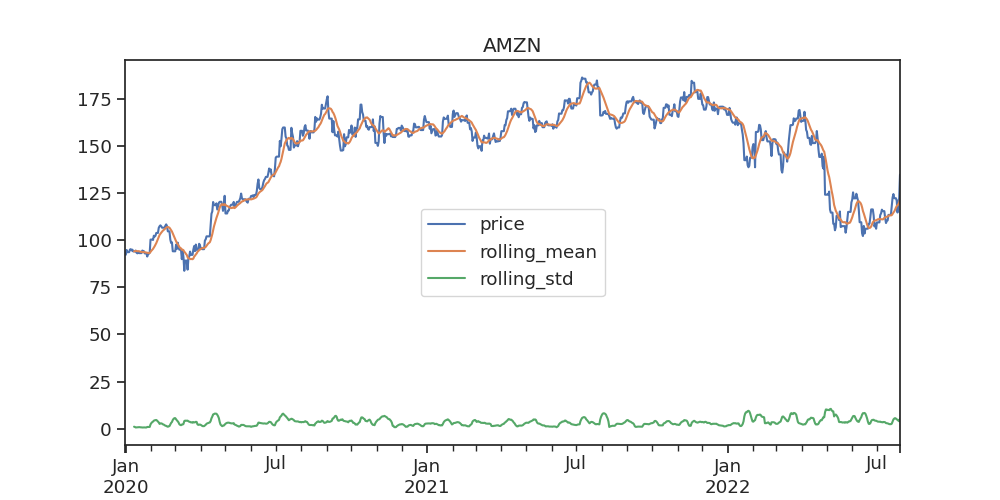

In [226]:
df.plot(title=ticker)

In [227]:
def decompose():
    decomposition_results = seasonal_decompose(df['price'], model='multiplicative')
    fig = decomposition_results.plot()
    fig.suptitle('Multiplicative Decomposition')
    # fig.set_size_inches((16,9))
    fig.tight_layout()
    plt.show()

## Exponential smoothing methods

## ARIMA

## Additive Model using Facebook's Prophet

In [229]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'price': 'y'}, inplace=True)
df = df.loc[:, ['ds', 'y']]

In [230]:
df

,ds,y
0,2019-12-31,92.391998
1,2020-01-01,92.391998
2,2020-01-02,94.900497
3,2020-01-03,93.748497
4,2020-01-04,93.748497
...,...,...
937,2022-07-25,121.139999
938,2022-07-26,114.809998
939,2022-07-27,120.970001
940,2022-07-28,122.279999


In [235]:
start_forecast = datetime(2022, 7, 1)
end_forecast = df['ds'].max()

In [236]:
train_indices = df['ds'] < start_forecast
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [237]:
from fbprophet import Prophet

In [240]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -41.083
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2481.82   0.000977148       408.905      0.6825      0.6825      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2509.51    0.00303838       346.854       0.182      0.5555      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2519.01     0.0134715       374.414           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312        2521.6   0.000637221       384.704   5.255e-06       0.001      408  LS failed, Hessian reset 
     363       2524.79   9.08802e-05       116.144   7.704e-07       0.001      535  LS failed, Hessian reset 
     399        2525.7    0.00116091       134.212           1           1      582   
    Iter      log prob

      alpha0  # evals  Notes 
     499       2534.37     0.0071444       182.005           1           1      700   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     575       2536.44   0.000650537       150.048   4.262e-06       0.001      829  LS failed, Hessian reset 
     599       2537.26    0.00114968       133.572      0.3476      0.9503      854   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       2538.29    0.00157891       124.545           1           1      975   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2541.28    0.00388715       94.0538      0.6906      0.6906     1093   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     882       2541.59   5.92123e-05       66.0279   7.773e-07       0.001     1237  LS failed, Hessian reset 
     899       2541.59   5.23003

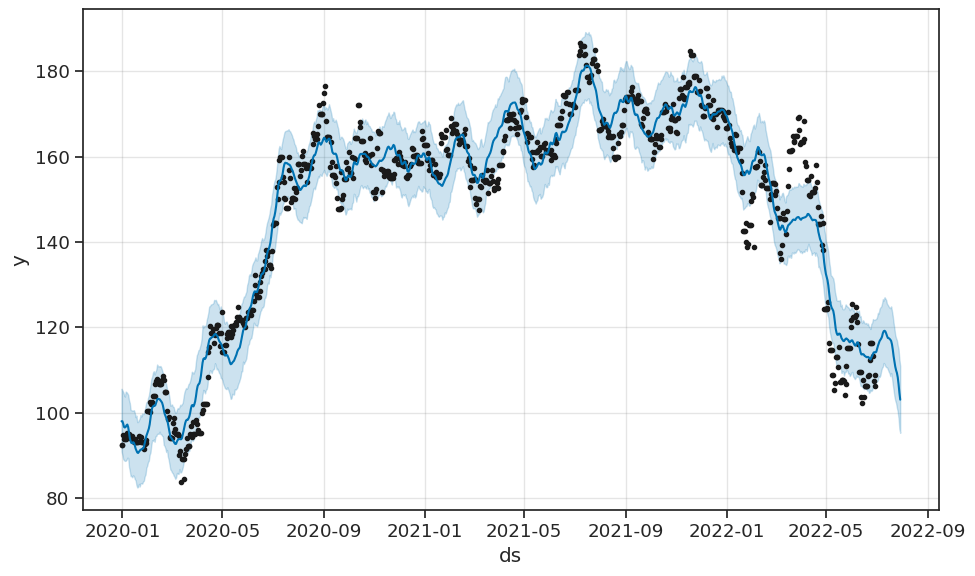

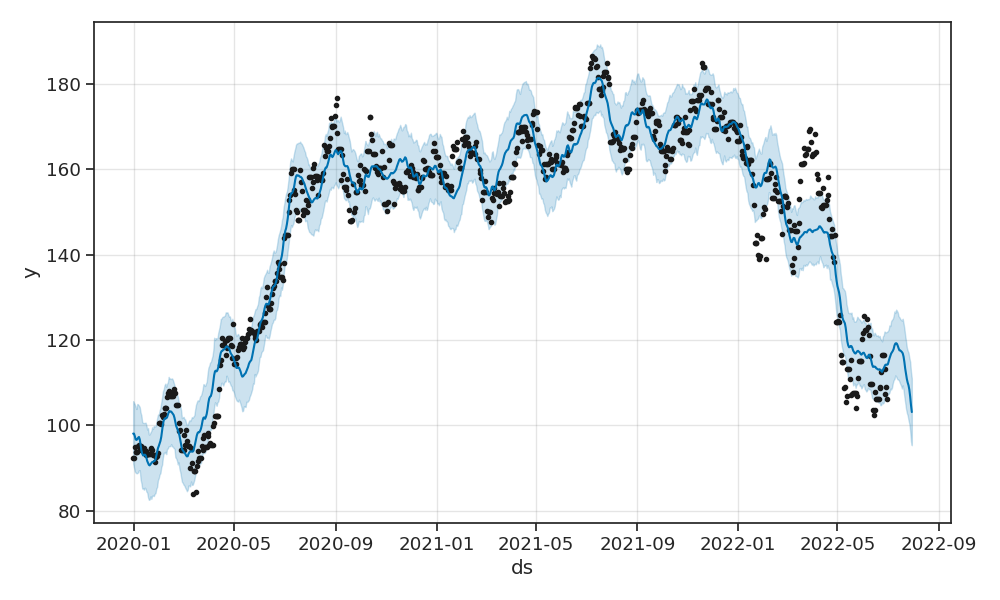

In [241]:
df_feature = model_prophet.make_future_dataframe(periods=30)
df_pred = model_prophet.predict(df_feature)
model_prophet.plot(df_pred)

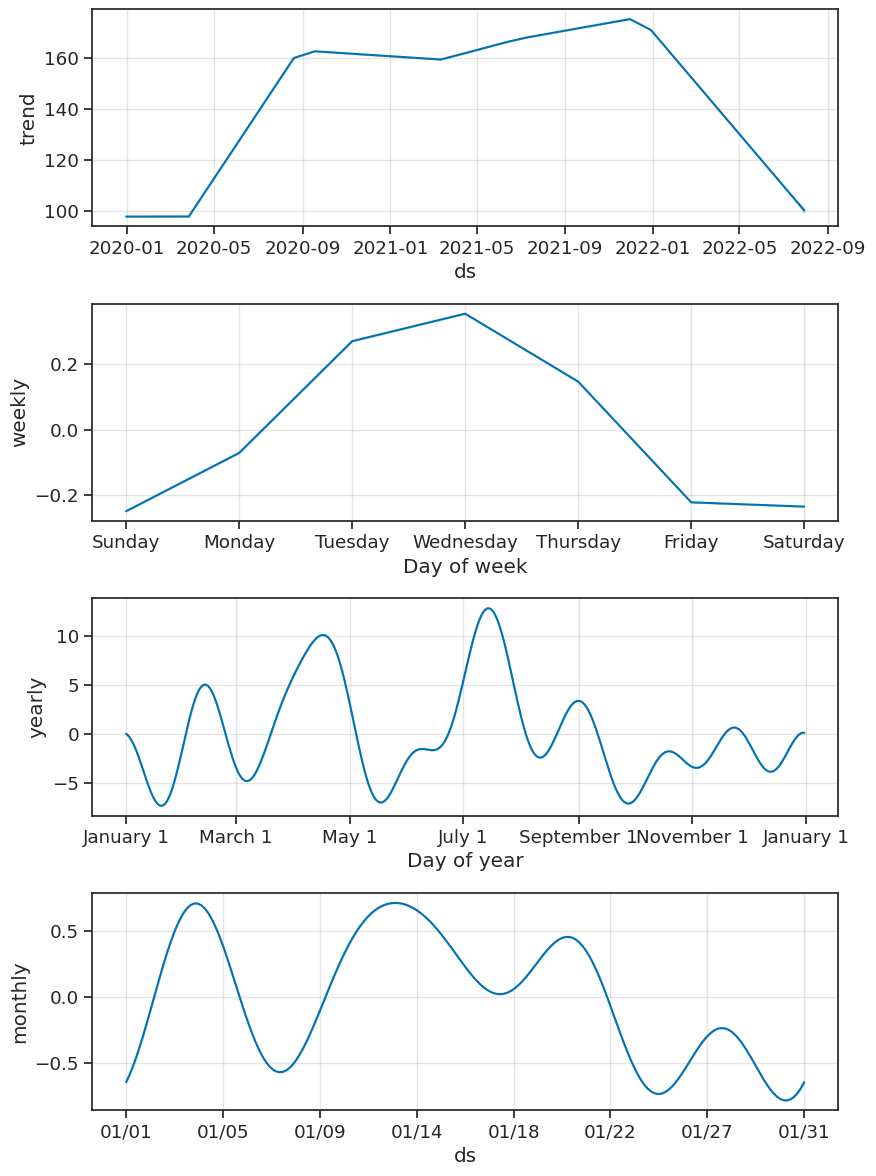

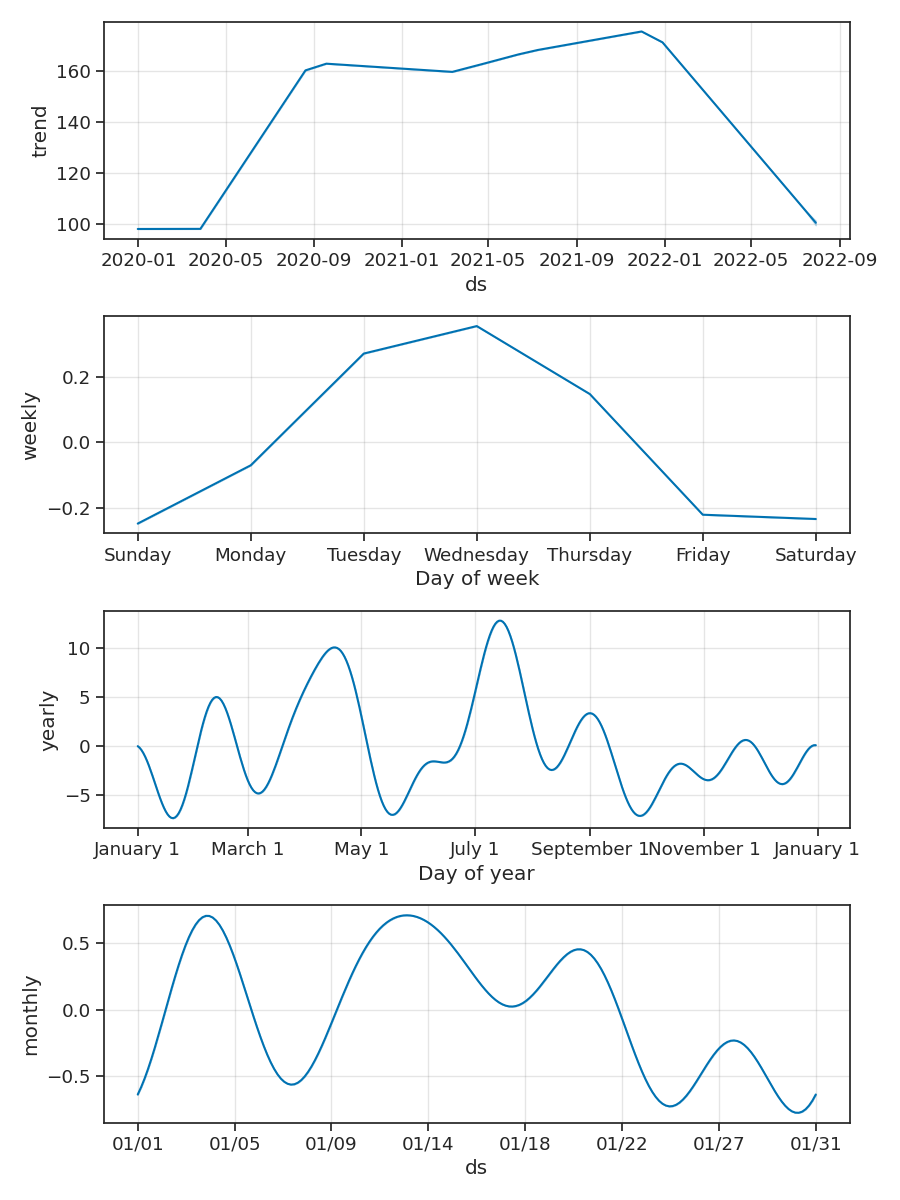

In [242]:
model_prophet.plot_components(df_pred)

## Evaluation
Information about basic performance of fitted model

In [243]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)

In [245]:
df_merged = df_test.merge(df_pred, on=['ds'], how='left')
df_merged['ds'] = pd.to_datetime(df_merged['ds'])
df_merged.set_index('ds', inplace=True)

[Text(0.5, 1.0, 'AMZN - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price ($)')]

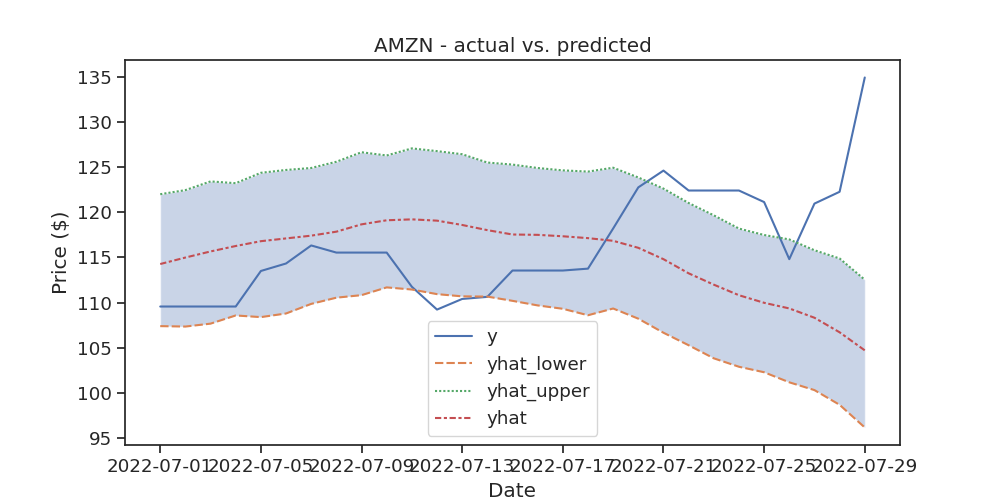

In [246]:
fig, ax = plt.subplots(1,1)
plot_columns = ['y', 'yhat_lower', 'yhat_upper', 'yhat']
ax = sns.lineplot(data=df_merged[plot_columns])
ax.fill_between(df_merged.index, df_merged['yhat_lower'], df_merged['yhat_upper'], alpha=0.3)
ax.set(title=f'{ticker} - actual vs. predicted', xlabel='Date', ylabel='Price ($)')

In [247]:
df_feature = model_prophet.make_future_dataframe(periods=365)


In [248]:
df_pred = model_prophet.predict(df_feature)

In [249]:
df_pred = pd.merge(df, df_pred[['ds', 'yhat_lower', 'yhat_upper', 'yhat']], on=['ds'], how='left')

In [250]:
df_pred['forecast'] = df_pred['ds'] >= datetime(2022,1,7)

In [251]:
from matplotlib.patches import Rectangle

In [252]:
plot_columns = ['y', 'yhat']
df_pred.set_index('ds', drop=True, inplace=True)


In [253]:
from datetime import datetime

Text(0.825, 0.1, 'Forecast')

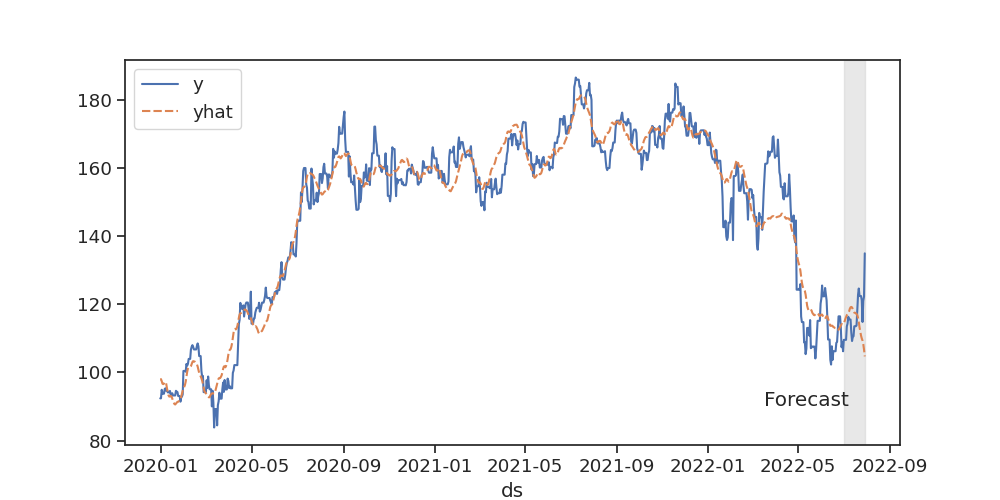

In [254]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=df_pred[plot_columns])
ax.axvspan(start_forecast, end_forecast, alpha=0.5, color='lightgrey')
ax.annotate('Forecast', xy=(0.825,0.1), xycoords='axes fraction')
